In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
mnist = keras.datasets.mnist
cifar10 = keras.datasets.cifar10

database = 1
if (database) : 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
else : 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

print(y_train.shape)
# Preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

(50000,)


In [57]:
batch_size = 64
epochs = 5

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=x_train.shape[1:4]),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)), #, kernel_regularizer=l2(0.01)
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [62]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True
    # Evaluate the model on the test set after each epoch
    test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)

    # If you want to use the test accuracy in your plot
    logs['test_acc'] = test_acc

callbacks = myCallback()

In [63]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
401/704 [================>.............] - ETA: 33s - loss: 2.1306 - acc: 0.2589

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.0733 - acc: 0.9916


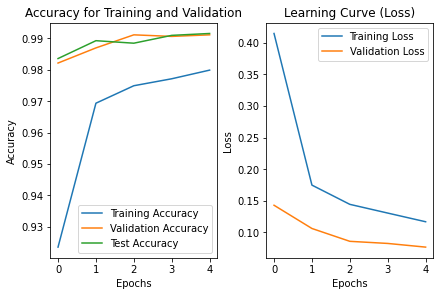

In [12]:
# 1. Plot accuracy for training, validation, and testing on one graph
fig, ax = plt.subplots(2,2,constrained_layout = True)
plt.subplot(121)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.plot(history.history['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for Training and Validation')

# 2. Plot learning curve (loss)
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve (Loss)')
plt.show()


/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  del sys.path[0]


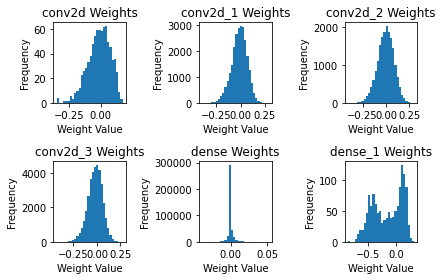

In [13]:
# 3. Histograms of each layer's weights
fig, ax = plt.subplots(2,3,constrained_layout = True)
i=0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        plt.subplot(2, 3, i+1)
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), bins=30)
        plt.title(f'{layer.name} Weights')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        i = i+1
fig.tight_layout()
plt.show()

313/313 [==============================] - 4s 12ms/step


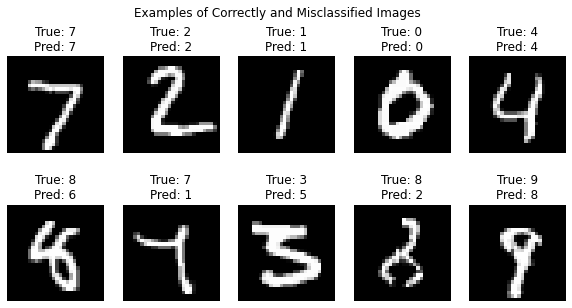

In [14]:
# 4. Show examples of correctly classified and miss-classified images
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

correctly_classified_indices = np.where(y_pred == y_true)[0]
misclassified_indices = np.where(y_pred != y_true)[0]

# Display some correctly classified images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[correctly_classified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[correctly_classified_indices[i]]}\nPred: {y_pred[correctly_classified_indices[i]]}')
    plt.axis('off')

# Display some misclassified images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_test[misclassified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[misclassified_indices[i]]}\nPred: {y_pred[misclassified_indices[i]]}')
    plt.axis('off')

plt.suptitle('Examples of Correctly and Misclassified Images')
plt.show()


1/1 [==============================] - 0s 68ms/step


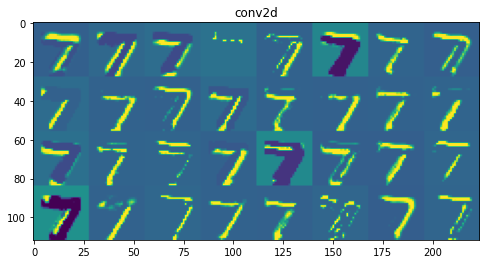

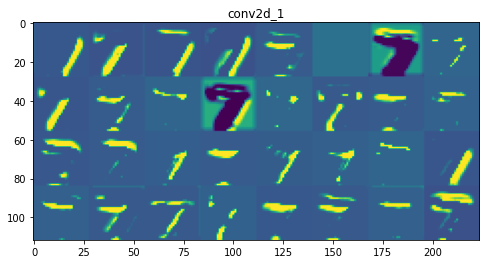

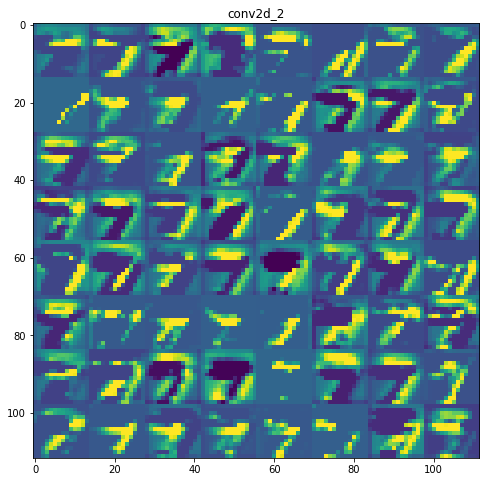

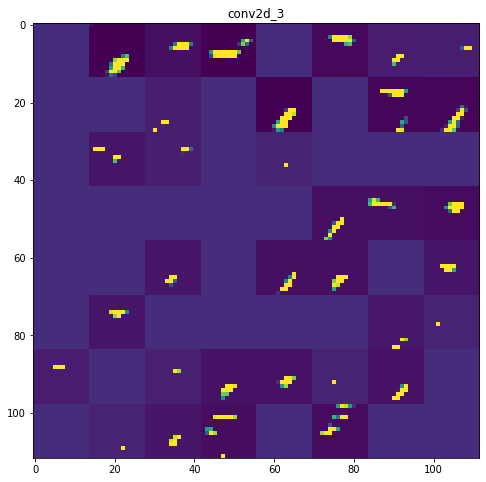

In [15]:
# Observe feature maps from different convolutional layers
layer_outputs = [layer.output for layer in model.layers[:6]]  # Extracting the output of the first six layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

example_image = x_test[0].reshape(1, 28, 28, 1)  # Take the first test image for visualization
activations = activation_model.predict(example_image)

# Plot the feature maps
layer_names = [layer.name for layer in model.layers[:6]]

for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv' in layer_name:
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // 8  # Display up to 8 feature maps per row
        display_grid = np.zeros((size * n_cols, 8 * size))

        for col in range(n_cols):
            for row in range(8):
                channel_image = layer_activation[0, :, :, col * 8 + row]
                channel_image -= channel_image.mean()
                channel_image_std = channel_image.std()
                channel_image_std = channel_image_std if channel_image_std > 0 else 1e-10  # Avoid division by zero
                channel_image /= channel_image_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image


        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [16]:
# There are a few points we can infer from this:

# This first layer retains almost the full shape of the image, and also most of the information present in the image
# As we go deeper into the network we can see that the activations become more complex and abstract. It starts encoding high-level features such as edges, curves and angles.
# Also as we go deeper we can see that many of our filters are not getting activated, which shows our model is reaching it’s learning capacity.

In [17]:
cifar10 = keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


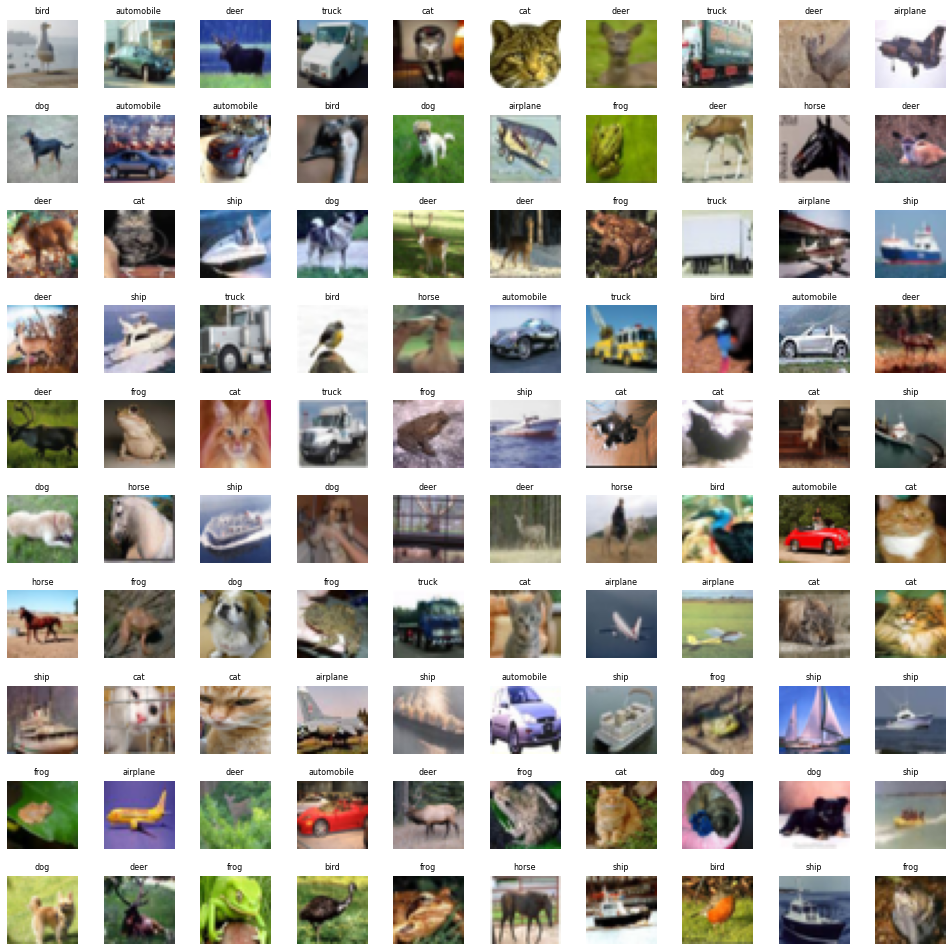

In [18]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

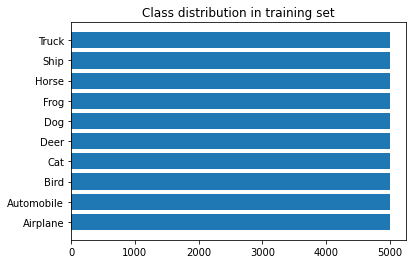

In [19]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

In [21]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [22]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
      self.asyncio_loop.run_forever()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
      ret = callback()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
      return fn(*args, **kwargs)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
      self.run()
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
      yielded = self.gen.send(value)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
      user_expressions, allow_stdin,
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-22-623d9b874171>", line 5, in <module>
      callbacks=[callbacks])
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/losses.py", line 278, in call
      y_pred, y_true
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/utils/losses_utils.py", line 210, in squeeze_or_expand_dimensions
      tf.equal(1, rank_diff), maybe_squeeze_dims, squeeze_dims
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/utils/losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/utils/losses_utils.py", line 158, in remove_squeezable_dimensions
      lambda: labels,
    File "/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/utils/losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze'
Can not squeeze dim[2], expected a dimension of 1, got 10
	 [[{{node categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze}}, {{node cond/remove_squeezable_dimensions/cond/Squeeze}}]] [Op:__inference_train_function_32168]